In [7]:
import gurobipy as gp
from gurobipy import GRB

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import time, random

In the file ```graph1.gml``` you can find an example graph including weights. The optimal value should be ```14.8547```

In [9]:
G = nx.read_gml("graph1.gml")

You can also un-comment the following cell to get other graphs

In [33]:
G = nx.erdos_renyi_graph(100, 0.01, directed=True)
for e in G.edges:
    G.edges[e]['weight'] = random.uniform(0,1)

In [34]:
# Will be handy later
edge_weight_dict = {e: G.edges[e]['weight'] for e in G.edges}

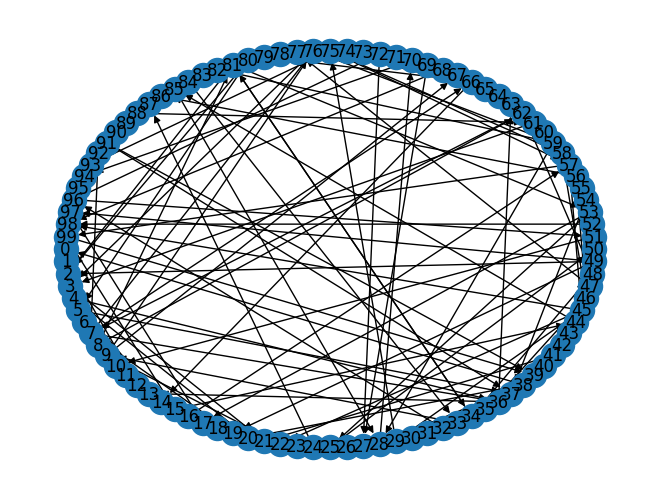

In [35]:
# We can also draw the graph
nx.draw_shell(G, with_labels=True)

We will consider all nodes that have no incoming edges as NDDs. If they were patients, we could remove them in a preprocessing step.

In [13]:
non_directed = [v for v in G.nodes if G.in_degree(v) == 0]
# the rest are patients
patients = [v for v in G.nodes if v not in non_directed]

In [14]:
# Will be handy later. Given a graph and edge-variables y, returns the edges that are selected
def selected_edges(G, y):
    return [e for e in G.edges if y[e].X > 0.5]

In [15]:
# Plotting code. You don't have to read that
def plot_graph_selection(G, selected_edges, cycle_edges=None):
    # pos = nx.shell_layout(G)
    fig = plt.figure(1, figsize=(20, 20), dpi=60)
    pos = nx.circular_layout(G)
    options = {"edgecolors": "tab:gray", "node_size": 300, "alpha": 0.9}
    nx.draw_networkx_nodes(G, pos, nodelist=non_directed, node_color="tab:red", **options)
    nx.draw_networkx_nodes(G, pos, nodelist=patients, node_color="tab:blue", **options)
    nx.draw_networkx_labels(G, pos)

    # edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=selected_edges,
        width=4,
        alpha=0.5,
        edge_color="tab:red",
    )
    if cycle_edges:
        nx.draw_networkx_edges(
        G,
        pos,
        edgelist=cycle_edges,
        width=4,
        alpha=0.5,
        edge_color="tab:green",
    )

The following function will be used to find all cycles that violate the upper bound $k$. That is, we are given the graph $G$, a set of selected edges (that will fulfill the degree constraints!) and an upper bound $k$. In this setting, we can use the simple procedure discussed in the recitation session to find cycles that are longer than $k$. Because it will be useful later, we will both return the edges in the cycles as well as the nodes that occur.

In [16]:
# Example output:
# {'edges': [[('1', '2'), ('2', '3'), ('3', '4'), ('4', '1')],
#            [('5', '6'), ('6', '7'), ('7', '8'), ('8', '9'), ('9', '1')]], 
#  'nodes': [['1', '2', '3', '4'],
#           ['5', '6', '7', '8', '9']]
#           }

NetworkX does provide us with nice functions like ```DiGraph.in_edges```, ```DiGraph.in_degree``` and ```DiGraph.successors```. Please use them to implement your function that finds violating cycles. There is also a function called ```nx.simple_cycles```. It also works in higher degree graphs but I ask you to implement the procedure we discussed in the rectiation section (which is also probably more efficient because we make use of the fact the graph has in_degree and out_degree of at most 1!)

In [17]:
def find_violating_cycles(G, edges_in_solution, k):
    G_sol = nx.DiGraph()
    G_sol.add_nodes_from(G.nodes)
    G_sol.add_edges_from(edges_in_solution)
    violating_edge_cycles = []
    violating_node_cycles = []

    
    # TODO
    explored_node = [] #store already explored nodes so that we don't explore them twice
    for node in G_sol.nodes:
        if node not in explored_node:
            current_node_exploration = [node] # path/cycle generated by node
            current_edge_exploration = []
            explored_node.append(node)
            list_succ = list(G_sol.successors(node))
            while len(list_succ) and list_succ[0] not in explored_node :
                # Node has an unexplored successor 
                succ = list_succ[0]
                current_node_exploration.append(succ)
                current_edge_exploration.append((node,succ))
                explored_node.append(succ)
                node = succ
                list_succ = list(G_sol.successors(node))
            # There is either no unexplored successor or no successor to node
            if len(list_succ) and list_succ[0] in current_node_exploration:
                # We found a cycle
                succ = list_succ[0]
                current_edge_exploration.append((node,succ))
                if len(current_node_exploration)>k:
                    violating_edge_cycles.append(current_edge_exploration)
                    violating_node_cycles.append(current_node_exploration)
    return {'edges': violating_edge_cycles, 'nodes': violating_node_cycles}

In [18]:
# Given a list of violating cycles, we add the corresponding inequalities to the model. The function is given the y variables from
# the model explicitly to make implementation easier
def add_cycle_constraints(model, y, violating_cycles):
    for cycle in violating_cycles:
        model.addConstr(
            # TODO
            gp.quicksum(y[e] for e in cycle) <= len(cycle)-1
        )

In [19]:
# Partitions the edges into cycle edges and non-cycle edges. Used for coloring cycle edges later
def split_cycles(G, y):    
    selected_cycles = find_violating_cycles(G, edges_in_solution=selected_edges(G, y), k=1)['edges']
    edges_appearing_in_cycles = []
    for c in selected_cycles:
        edges_appearing_in_cycles += c
    non_cycles = [e for e in selected_edges(G, y) if e not in edges_appearing_in_cycles]
    return edges_appearing_in_cycles, non_cycles

## Recursive Model

In [20]:
def recursive_alg(G, k=3):

    # create model
    model_recursive = gp.Model()
    model_recursive.setParam('OutputFlag', 0)
    model_recursive.ModelSense=GRB.MAXIMIZE

    # create vars
    y_s = model_recursive.addVars(G.edges, obj=edge_weight_dict, vtype=GRB.BINARY, name='y')
    f_in = model_recursive.addVars(G.nodes, obj=0, vtype=GRB.CONTINUOUS, name='f_in')
    f_out = model_recursive.addVars(G.nodes, obj=0, vtype=GRB.CONTINUOUS, name='f_out')

    # constraints
    inflow_constraint = model_recursive.addConstrs(
        # TODO
        gp.quicksum(y_s[e] for e in G.in_edges(v)) == f_in[v] for v in G.nodes
    )
    outflow_constraint = model_recursive.addConstrs(
        # TODO
        gp.quicksum(y_s[(v,s)] for s in G.successors(v)) == f_out[v] for v in G.nodes
    )
    out_smaller_in = model_recursive.addConstrs(
        # TODO
        f_out[v] <= f_in[v] for v in G.nodes if G.in_degree(v) > 0
    )
    in_smaller_one= model_recursive.addConstrs(
        # TODO
        f_in[v] <= 1 for v in G.nodes if G.in_degree(v) > 0
    )
    out_smaller_one= model_recursive.addConstrs(
        # TODO
        f_out[v] <= 1 for v in G.nodes if G.in_degree(v) == 0
    )

    # initial run
    model_recursive.optimize()
    
    # recursive loop
    violating_cycles = find_violating_cycles(G, edges_in_solution=selected_edges(G, y_s), k=k)['edges']
    while len(violating_cycles) > 0:
        # TODO
        add_cycle_constraints(model_recursive, y_s, violating_cycles)
        model_recursive.optimize()
        violating_cycles = find_violating_cycles(G, edges_in_solution=selected_edges(G, y_s), k=k)['edges']

    # For plotting purposes, let's detect all cycles that are in our solution
    edges_appearing_in_cycles, non_cycles = split_cycles(G, y_s)
    plot_graph_selection(G, non_cycles, cycle_edges=edges_appearing_in_cycles)
    
    return model_recursive.ObjVal
    

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-23


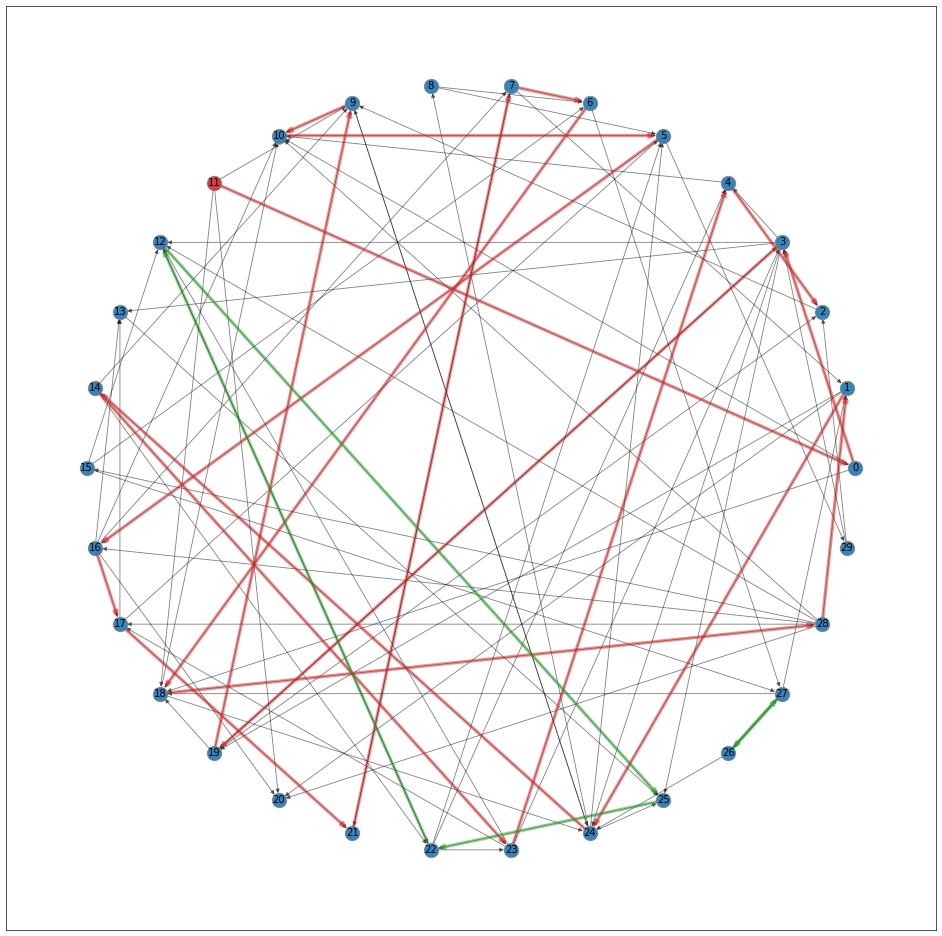

In [21]:
# Let's time it!
t1 = time.time()
recursive_obj_val = recursive_alg(G, k=3)
t2 = time.time()
recursive_time = t2 - t1

## Simple Model with Lazy Constraints

For the lazy constraints, Gurobi needs a so-called callback function of the form ```function_name(model, where)```. To make our lives easier, we put a wrapper around our callback function, so that we can provide $G$, $y$ and $k$.

In [22]:
def cycle_elimination_callback(G, y, k):
    def cycle_elimination(model, where):
        if where == GRB.Callback.MIPSOL:
            edges_in_solution = [e for e in G.edges if model.cbGetSolution(y[e]) > 0.5]
            violating_cycles = find_violating_cycles(G=G, edges_in_solution=edges_in_solution, k=k)['edges']
            for c in violating_cycles:
                model.cbLazy(
                    # TODO: Add the cycle constraint
                    gp.quicksum(y[e] for e in c) <= len(c)-1
                )
    return cycle_elimination

In [23]:
def lazy_cycles(G, k=3):
    # create model
    model_lazy_cycles = gp.Model()
    model_lazy_cycles.setParam('OutputFlag', 0)
    model_lazy_cycles.ModelSense=GRB.MAXIMIZE
    
    # create vars
    y_s = model_lazy_cycles.addVars(G.edges, obj=edge_weight_dict, vtype=GRB.BINARY, name='y')
    f_in = model_lazy_cycles.addVars(G.nodes, obj=0, vtype=GRB.CONTINUOUS, name='f_in')
    f_out = model_lazy_cycles.addVars(G.nodes, obj=0, vtype=GRB.CONTINUOUS, name='f_in')

    # constraints
    inflow_constraint = model_lazy_cycles.addConstrs(
        # TODO
        gp.quicksum(y_s[e] for e in G.in_edges(v)) == f_in[v] for v in G.nodes
    )
    outflow_constraint = model_lazy_cycles.addConstrs(
        # TODO
        gp.quicksum(y_s[(v,s)] for s in G.successors(v)) == f_out[v] for v in G.nodes
    )
    out_smaller_in = model_lazy_cycles.addConstrs(
        # TODO
        f_out[v] <= f_in[v] for v in G.nodes if G.in_degree(v) > 0
    )
    in_smaller_one= model_lazy_cycles.addConstrs(
        # TODO
        f_in[v] <= 1 for v in G.nodes if G.in_degree(v) > 0
    )
    out_smaller_one= model_lazy_cycles.addConstrs(
        # TODO
        f_out[v] <= 1 for v in G.nodes if G.in_degree(v) == 0
    )

    # use lazy constraints
    model_lazy_cycles.Params.lazyConstraints = 1
    model_lazy_cycles.optimize(cycle_elimination_callback(G=G, y=y_s, k=k))

    edges_appearing_in_cycles, non_cycles = split_cycles(G, y_s)
    plot_graph_selection(G, non_cycles, cycle_edges=edges_appearing_in_cycles)
    
    return model_lazy_cycles.ObjVal
    

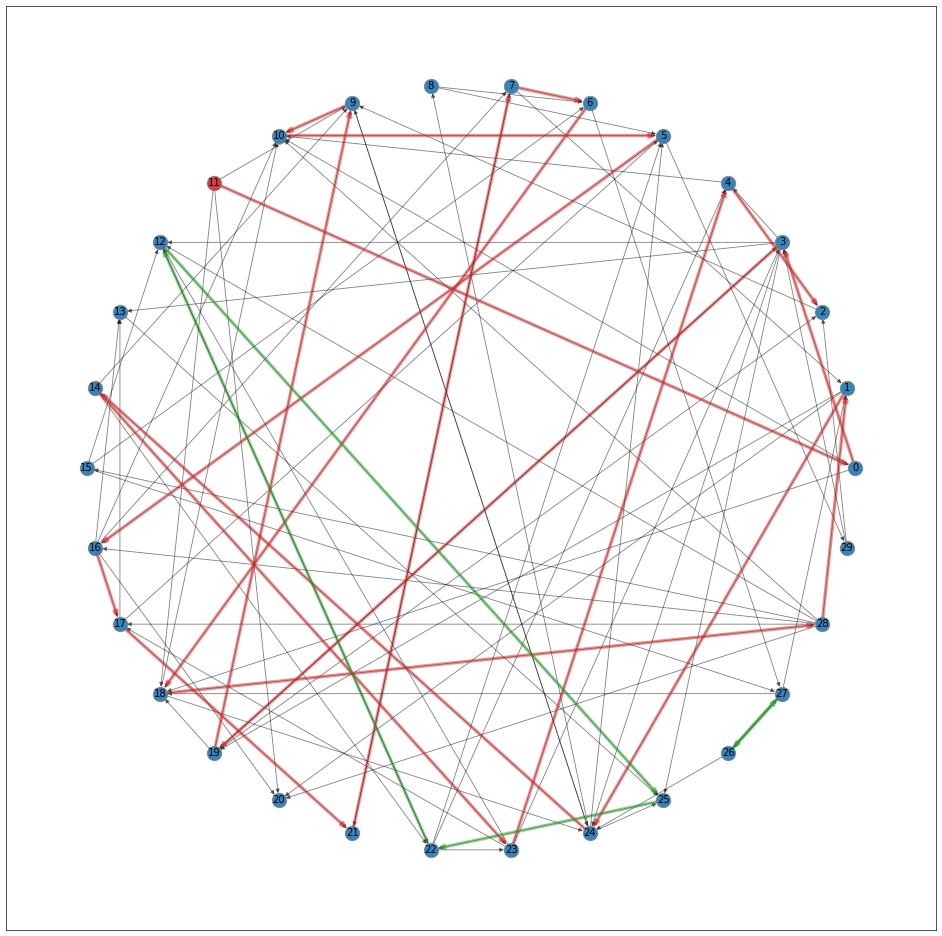

In [24]:
# time it again
t1 = time.time()
lazy_cycle_obj_val = lazy_cycles(G, k=3)
t2 = time.time()
lazy_cycle_time = t2 - t1

### PC-TSP

In [25]:
# Given a cycle represented by the nodes appearing, transform it into its edge representation
def transform_into_edge_cycle(cycle):
    edge_cycle = []
    for j in range(len(cycle)):
        edge_cycle += [(cycle[j], cycle[(j + 1) % len(cycle) ])]
    return edge_cycle

In [26]:
# A wrapper again
def cut_callback(G, y, f_in):
    def cut_inequality(model, where):
        if where == GRB.Callback.MIPSOL:
            edges_in_solution = [e for e in G.edges if model.cbGetSolution(y[e]) > 0.5]
            violated_cycles = find_violating_cycles(G=G, edges_in_solution=edges_in_solution, k=1)
            for c in violated_cycles['nodes']:
                complement = [v for v in G.nodes() if v not in c]
                # edges going from the complement of c to c
                # nx.boundary(G, A, B) returns the edges in G going from A to B
                edges_in_cut = nx.edge_boundary(G, complement, c)
                model.cbLazy(
                    # TODO: Add Cut Constraint
                    gp.quicksum(y[e] for e in edges_in_cut) >= f_in[c[0]]
                )
    return cut_inequality

In [27]:
# Will be handy in the constraint definitions. Given a list of cycles in edge representation, returns the sub-list of cycles
# that contain the given node
def edge_cycles_that_contain_node(cycles, node):
    containing_node = []
    for c in cycles:
        if node in [e[0] for e in c]:
            containing_node += [c]
    return containing_node

In [28]:
def PC_TSP(G, k=3):
    # Let's use NetworkX functionality to get all cycles
    node_cycles = nx.simple_cycles(G, length_bound=k)
    edge_cycles = [tuple(transform_into_edge_cycle(c)) for c in node_cycles]
    cycle_weight_dict = {c: sum([G.edges[e]['weight'] for e in c]) for c in edge_cycles}

    # create model
    model_pc_tsp = gp.Model()
    model_pc_tsp.setParam('OutputFlag', 0)
    model_pc_tsp.ModelSense=GRB.MAXIMIZE

    # create vars
    y_s = model_pc_tsp.addVars(G.edges, obj=edge_weight_dict, vtype=GRB.BINARY, name='y')
    z_s = model_pc_tsp.addVars(edge_cycles, obj=cycle_weight_dict, vtype=GRB.BINARY, name='z')
    f_in = model_pc_tsp.addVars(G.nodes, obj=0, vtype=GRB.CONTINUOUS, name='f_in')
    f_out = model_pc_tsp.addVars(G.nodes, obj=0, vtype=GRB.CONTINUOUS, name='f_out')
    
    # constraints
    inflow_constraint = model_pc_tsp.addConstrs(
        # TODO
        gp.quicksum(y_s[e] for e in G.in_edges(v)) == f_in[v] for v in G.nodes
    )
    outflow_constraint = model_pc_tsp.addConstrs(
        # TODO
        gp.quicksum(y_s[(v,s)] for s in G.successors(v)) == f_out[v] for v in G.nodes
    )
    out_smaller_in = model_pc_tsp.addConstrs(
        # TODO
        f_out[v] <= f_in[v] for v in G.nodes if G.in_degree(v) > 0
    )
    in_smaller_one = model_pc_tsp.addConstrs(
        # TODO
        f_in[v] + gp.quicksum(z_s[c] for c in edge_cycles_that_contain_node(edge_cycles, v)) <= 1 for v in G.nodes if G.in_degree(v) > 0
    )
    out_smaller_one = model_pc_tsp.addConstrs(
        # TODO
        f_out[v] <= 1 for v in G.nodes if G.in_degree(v) == 0
    )

    # solve with lazy constraint callback
    model_pc_tsp.Params.lazyConstraints = 1
    model_pc_tsp.optimize(cut_callback(G=G, y=y_s, f_in=f_in))
    
    selected_cycles = [c for c in edge_cycles if z_s[c].X > 0.5]
    edges_appearing_in_cycles = []
    for c in selected_cycles:
        edges_appearing_in_cycles += c
    plot_graph_selection(G, selected_edges(G, y_s), cycle_edges=edges_appearing_in_cycles)
    
    return model_pc_tsp.ObjVal

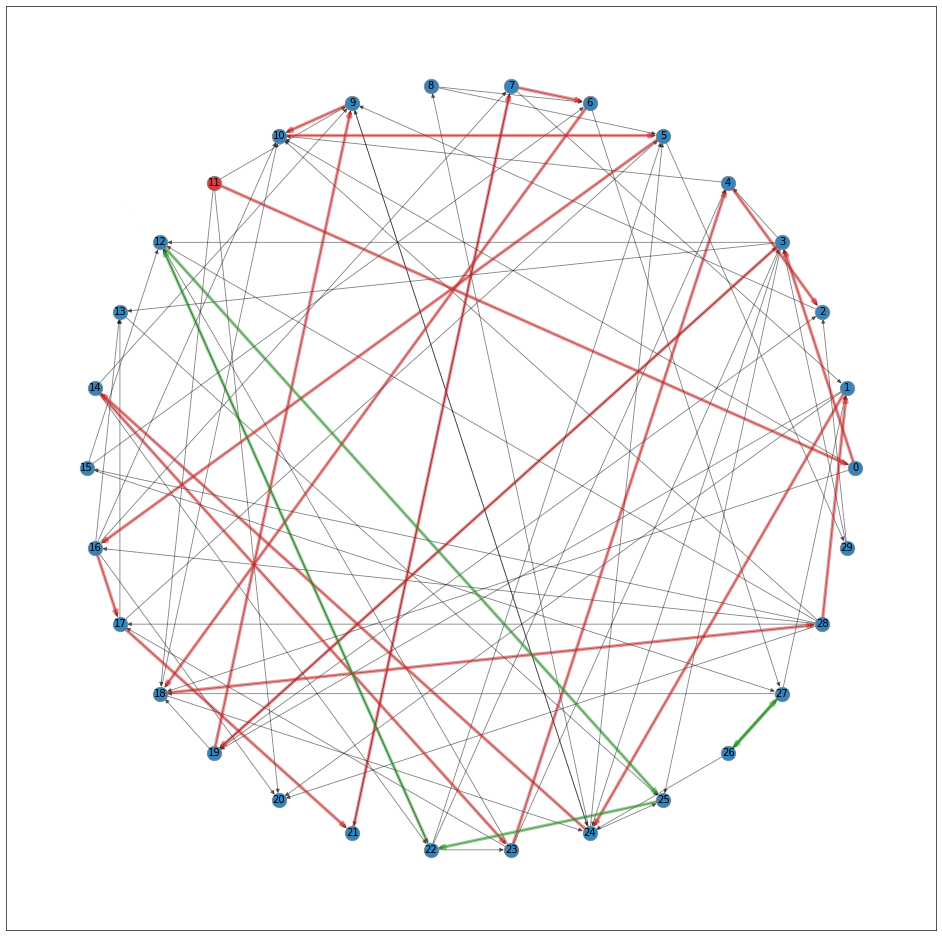

In [29]:
# Timing one last time
t1 = time.time()
pctsp_obj_val = PC_TSP(G, k=3)
t2 = time.time()
pctsp_time = t2 - t1

In [30]:
# Check whether we get the same objective function value everywhere
recursive_obj_val, lazy_cycle_obj_val, pctsp_obj_val

(14.85470549759799, 14.85470549759799, 14.85470549759799)

In [32]:
# Running times
print('Running times:')
print(f'Recursive Model: \t\t\t{recursive_time}')
print(f'Recusive Model with Lazy Constraints: \t{lazy_cycle_time}')
print(f'PC-TSP Model: \t\t\t\t{pctsp_time}')

Running times:
Recursive Model: 			0.21954727172851562
Recusive Model with Lazy Constraints: 	0.16196489334106445
PC-TSP Model: 				0.19922304153442383
